In [1]:
import os

import pandas as pd
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
import numpy as np

RESULTS_FOLDER = "../../results"


IRL_METHOD = "maxent"
METHOD_STR_IRL = {
    f"ace_{IRL_METHOD}": "AceIRL Greedy",
    f"ace_ci_{IRL_METHOD}": "AceIRL Full",
    "us": "Uniform Sampling (generative)",
    "rand_expl": "Random Exploration",
    f"travel_{IRL_METHOD}": "TRAVEL (generative)",
}

METHOD_STR_RF = {
    f"ace_{IRL_METHOD}": "RF-UCRL",
    f"ace_ci_no_eps_{IRL_METHOD}": "Ace-RF",
    "us": "Uniform Sampling (generative)",
    "rand_expl": "Random Exploration",
}

In [2]:
def process_ace_results(
    data, percentiles=False, stderr_fac=1.96, eval_thresh=0.05, rf=False
):
    n_runs = int(data.columns[-1].split("_")[-1]) + 1
    method_str = METHOD_STR_RF if rf else METHOD_STR_IRL
    experiment = pd.DataFrame()

    for met_str in method_str:
        if not f"sample_{met_str}_0" in data.columns:
            print(f"Warning: {met_str} not in results.")
            continue

        try:
            sample_cols = [f"sample_{met_str}_{i}" for i in range(n_runs)]
            loss_cols = [f"loss_{met_str}_{i}" for i in range(n_runs)]

            samp = (data[loss_cols] <= eval_thresh).idxmax().tolist()
            sample_complexity = []

            for i, s in enumerate(samp):
                sample_complexity.append(data[sample_cols].iloc[s, i])

            mean = np.mean(sample_complexity)
            std = np.std(sample_complexity)
            n = len(sample_complexity)
            stderr = std / np.sqrt(n)
            print(
                f"Met: {method_str[met_str]}   mean: {mean}   std: {std}   n: {n}   stderr: {stderr}"
            )

            experiment[f"sample_{met_str}"] = data[sample_cols].mean(axis=1)

            if percentiles:
                experiment[f"loss_{met_str}_mean"] = data[loss_cols].median(axis=1)
                experiment[f"loss_{met_str}_lower"] = data[loss_cols].quantile(
                    0.25, axis=1
                )
                experiment[f"loss_{met_str}_upper"] = data[loss_cols].quantile(
                    0.75, axis=1
                )
            else:
                experiment[f"loss_{met_str}_mean"] = data[loss_cols].mean(axis=1)
                stderr = data[loss_cols].std(axis=1) / (n_runs**0.5)
                experiment[f"loss_{met_str}_lower"] = (
                    experiment[f"loss_{met_str}_mean"] - stderr_fac * stderr
                )
                experiment[f"loss_{met_str}_upper"] = (
                    experiment[f"loss_{met_str}_mean"] + stderr_fac * stderr
                )

        except Exception as e:
            print(e)

    return experiment


def plot_ace_results(experiment, title, rf=False):
    plt.figure(figsize=(6, 4), dpi=80)
    ax = plt.gca()
    method_str = METHOD_STR_RF if rf else METHOD_STR_IRL

    for met_str in method_str:
        try:
            experiment.plot(
                x=f"sample_{met_str}",
                y=f"loss_{met_str}_mean",
                label=method_str[met_str],
                ax=ax,
            )

            plt.fill_between(
                experiment[f"sample_{met_str}"],
                experiment[f"loss_{met_str}_lower"],
                experiment[f"loss_{met_str}_upper"],
                alpha=0.2,
            )
        except Exception as e:
            print(e)

    plt.suptitle(title)

    ax.set(xlabel="Sample")

# Active IRL Experiments

## Chain MDP

Met: AceIRL Greedy   mean: 152.8   std: 54.33378322922121   n: 50   stderr: 7.6839573137804456
Met: AceIRL Full   mean: 141.6   std: 63.76080300623573   n: 50   stderr: 9.017139235921778
Met: Uniform Sampling (generative)   mean: 78.2   std: 17.514565367145142   n: 50   stderr: 2.4769335881286767
Met: Random Exploration   mean: 160.8   std: 56.668862702545916   n: 50   stderr: 8.014187419819928
Met: TRAVEL (generative)   mean: 76.2   std: 25.681900241220468   n: 50   stderr: 3.6319691628646846


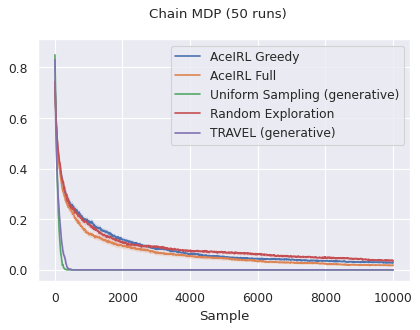

In [4]:
data = pd.read_csv(os.path.join(RESULTS_FOLDER, "result_aceirl_chain_mdp_50runs.csv"))
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Chain MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_chain_mdp_50runs.csv"),
    index=None,
)

## Random MDPs

Met: AceIRL Greedy   mean: 22.6   std: 6.8731361109758335   n: 50   stderr: 0.9720082304178294
Met: AceIRL Full   mean: 21.2   std: 8.4   n: 50   stderr: 1.1879393923933999
Met: Uniform Sampling (generative)   mean: 21.8   std: 8.1706792863262   n: 50   stderr: 1.1555085460523433
Met: Random Exploration   mean: 22.4   std: 7.08801805866774   n: 50   stderr: 1.0023971268913334
Met: TRAVEL (generative)   mean: 27.4   std: 9.961927524329816   n: 50   stderr: 1.4088293012285056


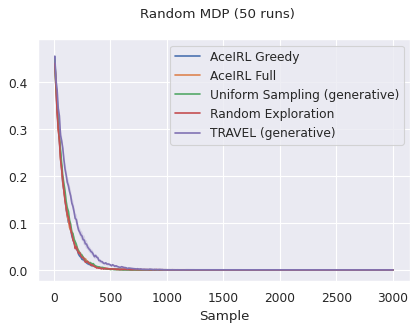

In [5]:
data = pd.read_csv(os.path.join(RESULTS_FOLDER, f"result_aceirl_random_mdp_50runs.csv"))
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Random MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_random_mdp_50runs.csv"),
    index=None,
)

# Gridworld

Met: AceIRL Greedy   mean: 45.6   std: 18.99052395275075   n: 50   stderr: 2.6856656530551226
Met: AceIRL Full   mean: 48.4   std: 16.414627622946554   n: 50   stderr: 2.3213789005675056
Met: Uniform Sampling (generative)   mean: 43.0   std: 14.177446878757825   n: 50   stderr: 2.004993765576342
Met: Random Exploration   mean: 45.0   std: 17.349351572897472   n: 50   stderr: 2.453568829277059
Met: TRAVEL (generative)   mean: 35.2   std: 12.687001221722962   n: 50   stderr: 1.794212919360464


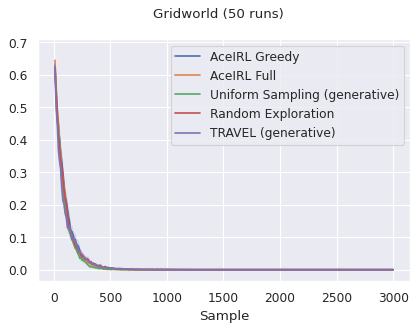

In [6]:
data = pd.read_csv(os.path.join(RESULTS_FOLDER, f"result_aceirl_gridworld_50runs.csv"))
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Gridworld ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_gridworld_50runs.csv"),
    index=None,
)

## Four Paths MDP

Met: AceIRL Greedy   mean: 24180.0   std: 12354.254327963303   n: 50   stderr: 1747.155402361221
Met: AceIRL Full   mean: 10780.0   std: 9681.508146977929   n: 50   stderr: 1369.1720125681798
Met: Uniform Sampling (generative)   mean: 1900.0   std: 500.0   n: 50   stderr: 70.71067811865476
Met: Random Exploration   mean: 17840.0   std: 13333.206666064994   n: 50   stderr: 1885.6001697072472
Met: TRAVEL (generative)   mean: 1560.0   std: 535.1635264103861   n: 50   stderr: 75.68355171369801


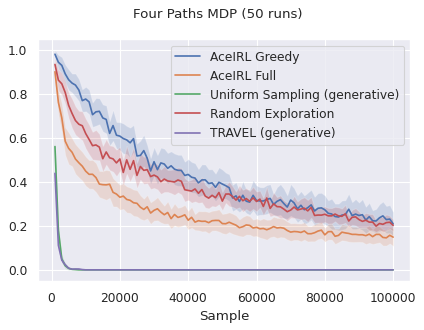

In [8]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_four_paths_50ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Four Paths MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_four_paths_50ep_50runs.csv"),
    index=None,
)

Met: AceIRL Greedy   mean: 32760.0   std: 15361.718653848598   n: 50   stderr: 2172.475086163245
Met: AceIRL Full   mean: 14080.0   std: 11334.61953485868   n: 50   stderr: 1602.9572670536168
Met: Uniform Sampling (generative)   mean: 2120.0   std: 474.9736834815167   n: 50   stderr: 67.17142249498666
Met: Random Exploration   mean: 19120.0   std: 13091.432312776169   n: 50   stderr: 1851.4081127617433
Met: TRAVEL (generative)   mean: 2000.0   std: 0.0   n: 50   stderr: 0.0


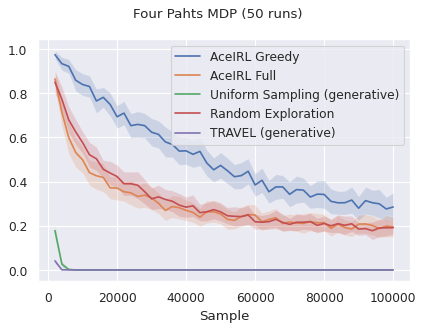

In [9]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_four_paths_100ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Four Pahts MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_four_paths_100ep_50runs.csv"),
    index=None,
)

Met: AceIRL Greedy   mean: 52000.0   std: 28688.673723265772   n: 50   stderr: 4057.1911465939093
Met: AceIRL Full   mean: 16160.0   std: 14376.870313110569   n: 50   stderr: 2033.1964981280091
Met: Uniform Sampling (generative)   mean: 4000.0   std: 0.0   n: 50   stderr: 0.0
Met: Random Exploration   mean: 22480.0   std: 16176.822926644156   n: 50   stderr: 2287.748237896819
Met: TRAVEL (generative)   mean: 4000.0   std: 0.0   n: 50   stderr: 0.0


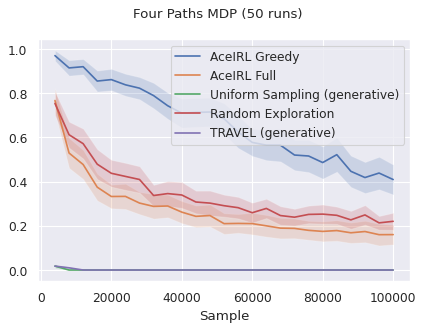

In [11]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_four_paths_200ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Four Paths MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_four_paths_200ep_50runs.csv"),
    index=None,
)

## Double Chain MDP

Met: AceIRL Greedy   mean: 16240.0   std: 5955.031486062857   n: 50   stderr: 842.1686291948898
Met: AceIRL Full   mean: 11580.0   std: 6154.965475126566   n: 50   stderr: 870.443565086215
Met: Uniform Sampling (generative)   mean: 1980.0   std: 468.61498055439927   n: 50   stderr: 66.27216610312357
Met: Random Exploration   mean: 23640.0   std: 15520.0   n: 50   stderr: 2194.8594488030435
Met: TRAVEL (generative)   mean: 1120.0   std: 324.96153618543843   n: 50   stderr: 45.95650117230423


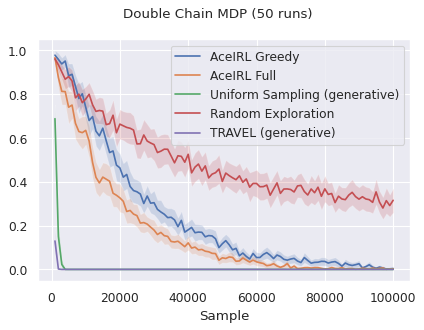

In [13]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_double_chain_50ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Double Chain MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_double_chain_50ep_50runs.csv"),
    index=None,
)

Met: AceIRL Greedy   mean: 22200.0   std: 9400.0   n: 50   stderr: 1329.3607486307094
Met: AceIRL Full   mean: 15440.0   std: 7288.785907131585   n: 50   stderr: 1030.789988309937
Met: Uniform Sampling (generative)   mean: 2280.0   std: 693.9740629158989   n: 50   stderr: 98.14275317108238
Met: Random Exploration   mean: 28920.0   std: 16781.942676579492   n: 50   stderr: 2373.3250936186555
Met: TRAVEL (generative)   mean: 2000.0   std: 0.0   n: 50   stderr: 0.0


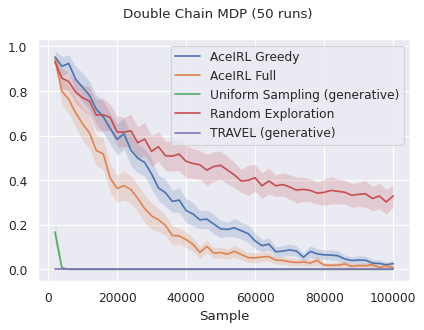

In [14]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_double_chain_100ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Double Chain MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_double_chain_100ep_50runs.csv"),
    index=None,
)

Met: AceIRL Greedy   mean: 37200.0   std: 11764.352935882194   n: 50   stderr: 1663.7307474468337
Met: AceIRL Full   mean: 20400.0   std: 11516.944039110374   n: 50   stderr: 1628.7418457201863
Met: Uniform Sampling (generative)   mean: 4000.0   std: 0.0   n: 50   stderr: 0.0
Met: Random Exploration   mean: 33360.0   std: 20169.045589714948   n: 50   stderr: 2852.3337813096136
Met: TRAVEL (generative)   mean: 4000.0   std: 0.0   n: 50   stderr: 0.0


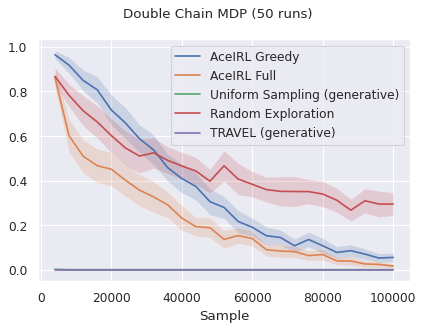

In [15]:
data = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "result_aceirl_double_chain_200ep_50runs.csv")
)
experiment = process_ace_results(data, eval_thresh=0.4)
n_runs = int(data.columns[-1].split("_")[-1]) + 1
plot_ace_results(experiment, f"Double Chain MDP ({n_runs} runs)")
experiment.to_csv(
    os.path.join(RESULTS_FOLDER, f"agg_results_double_chain_200ep_50runs.csv"),
    index=None,
)

#### Reward-free Exploration Experiments

N_E =  1000
Met: RF-UCRL   mean: 255600.0   std: 67798.52505770314   n: 50   stderr: 9588.15936454959
Met: Ace-RF   mean: 224000.0   std: 55425.62584220407   n: 50   stderr: 7838.367176906169
Met: Uniform Sampling (generative)   mean: 132000.0   std: 27712.812921102035   n: 50   stderr: 3919.1835884530847
Met: Random Exploration   mean: 391600.0   std: 226630.6245854695   n: 50   stderr: 32050.410293785633

N_E =  2000
Met: RF-UCRL   mean: 382400.0   std: 93692.26222052705   n: 50   stderr: 13250.08679216857
Met: Ace-RF   mean: 303200.0   std: 135785.7135342301   n: 50   stderr: 19202.999765661614
Met: Uniform Sampling (generative)   mean: 144800.0   std: 26400.0   n: 50   stderr: 3733.5238046649706
Met: Random Exploration   mean: 431200.0   std: 265123.6692564434   n: 50   stderr: 37494.148876858104

N_E =  3000
Met: RF-UCRL   mean: 562800.0   std: 156410.22984447022   n: 50   stderr: 22119.74683399428
Met: Ace-RF   mean: 356400.0   std: 122028.8490480837   n: 50   stderr: 17257.48533

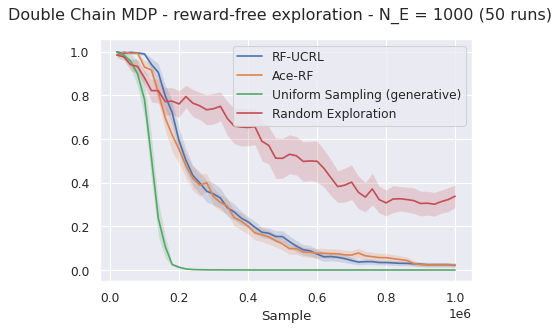

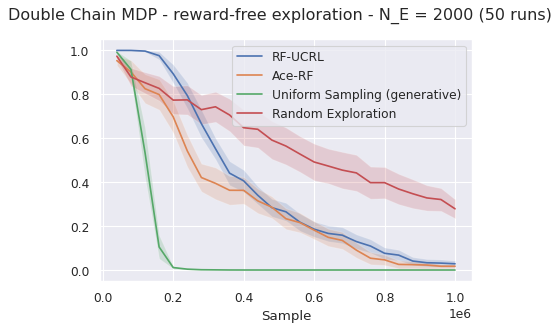

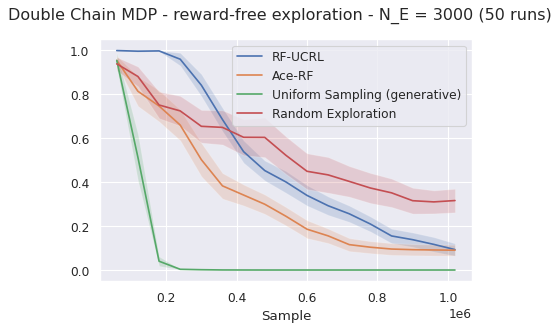

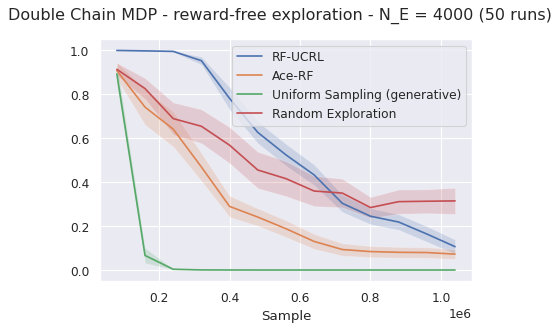

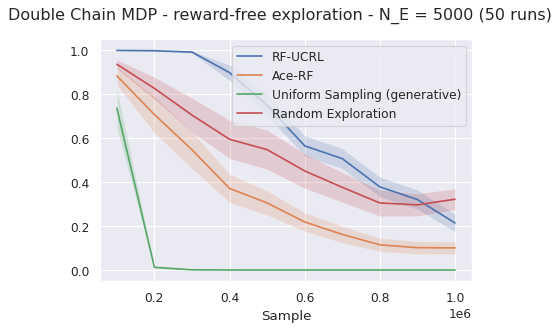

In [12]:
for n_ep in (1000, 2000, 3000, 4000, 5000):
    print("N_E = ", n_ep)
    data = pd.read_csv(
        os.path.join(
            RESULTS_FOLDER,
            "reward_free_exploration",
            f"result_double_chain_rfe_{n_ep}ep_50runs.csv",
        )
    )
    experiment = process_ace_results(data, eval_thresh=0.4, rf=True)
    n_runs = int(data.columns[-1].split("_")[-1]) + 1
    plot_ace_results(
        experiment,
        f"Double Chain MDP - reward-free exploration - N_E = {n_ep} ({n_runs} runs)",
        rf=True,
    )
    experiment.to_csv(
        os.path.join(
            RESULTS_FOLDER, f"agg_results_double_chain_rfe_{n_ep}ep_50runs.csv"
        ),
        index=None,
    )
    print()